# NOTE: This notebook is a copy of Trieste's code
[Source](https://secondmind-labs.github.io/trieste/4.5.1/notebooks/multi_objective_ehvi.html)

An equivalent problem is available through the GUI via MATLAb.
It has been included here to showcase the MOE scenario, on which we plan to work in the future

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import trieste
from trieste.acquisition.function import ExpectedHypervolumeImprovement
from trieste.acquisition.multi_objective.pareto import Pareto, get_reference_point
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.data import Dataset
from trieste.experimental.plotting import (
    plot_bo_points,
    plot_function_2d,
    plot_mobo_points_in_obj_space,
)
from trieste.models import TrainableModelStack
from trieste.models.gpflow import GaussianProcessRegression, build_gpr
from trieste.objectives.multi_objectives import VLMOP2
from trieste.space import Box, SearchSpace

np.random.seed(1793)
tf.random.set_seed(1793)

2025-12-19 15:37:39.705599: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-19 15:37:39.707674: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-19 15:37:39.739956: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-19 15:37:39.740684: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-19 15:37:40.242799: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
vlmop2 = VLMOP2(2)
observer = trieste.objectives.utils.mk_observer(vlmop2.objective)

In [3]:
mins = [-2, -2]
maxs = [2, 2]
search_space = Box(mins, maxs)
num_objective = 2
num_initial_points = 20
initial_query_points = search_space.sample(num_initial_points)
initial_data = observer(initial_query_points)

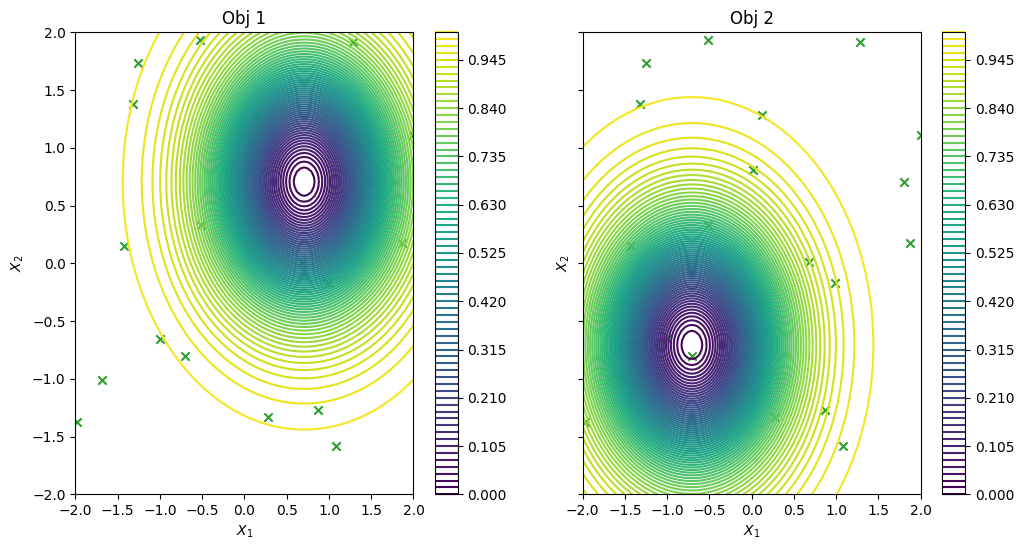

In [4]:
_, ax = plot_function_2d(
    vlmop2.objective,
    mins,
    maxs,
    contour=True,
    title=["Obj 1", "Obj 2"],
    figsize=(12, 6),
    colorbar=True,
    xlabel="$X_1$",
    ylabel="$X_2$",
)
plot_bo_points(initial_query_points, ax=ax[0, 0], num_init=num_initial_points)
plot_bo_points(initial_query_points, ax=ax[0, 1], num_init=num_initial_points)
plt.show()

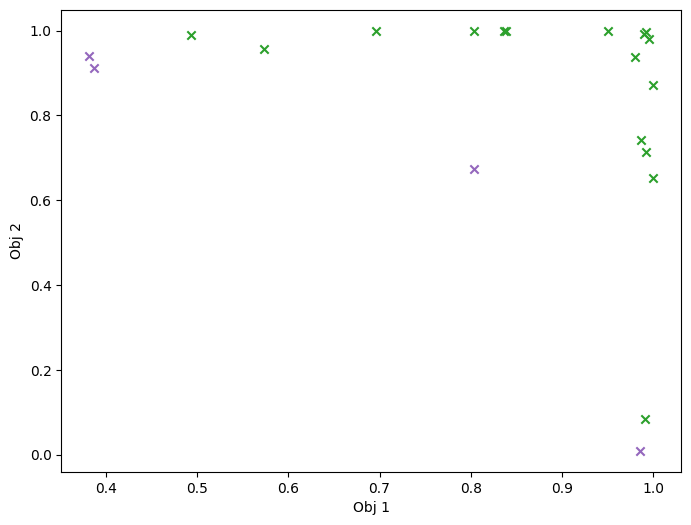

In [5]:
plot_mobo_points_in_obj_space(initial_data.observations)
plt.show()

In [6]:
def build_stacked_independent_objectives_model(
    data: Dataset, num_output: int, search_space: SearchSpace
) -> TrainableModelStack:
    gprs = []
    for idx in range(num_output):
        single_obj_data = Dataset(
            data.query_points, tf.gather(data.observations, [idx], axis=1)
        )
        gpr = build_gpr(single_obj_data, search_space, likelihood_variance=1e-7)
        gprs.append((GaussianProcessRegression(gpr), 1))

    return TrainableModelStack(*gprs)

In [7]:
model = build_stacked_independent_objectives_model(
    initial_data, num_objective, search_space
)
ehvi = ExpectedHypervolumeImprovement()
rule = EfficientGlobalOptimization(builder=ehvi)
num_steps = 30
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)
result = bo.optimize(num_steps, initial_data, model, acquisition_rule=rule)

Optimization completed without errors


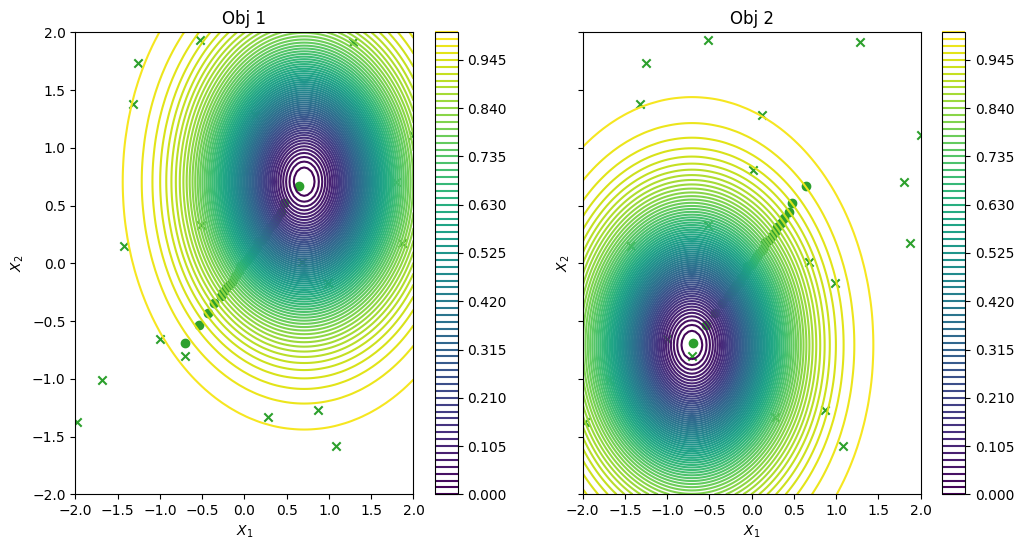

In [8]:
dataset = result.try_get_final_dataset()
data_query_points = dataset.query_points
data_observations = dataset.observations

_, ax = plot_function_2d(
    vlmop2.objective,
    mins,
    maxs,
    contour=True,
    figsize=(12, 6),
    title=["Obj 1", "Obj 2"],
    xlabel="$X_1$",
    ylabel="$X_2$",
    colorbar=True,
)
plot_bo_points(data_query_points, ax=ax[0, 0], num_init=num_initial_points)
plot_bo_points(data_query_points, ax=ax[0, 1], num_init=num_initial_points)
plt.show()

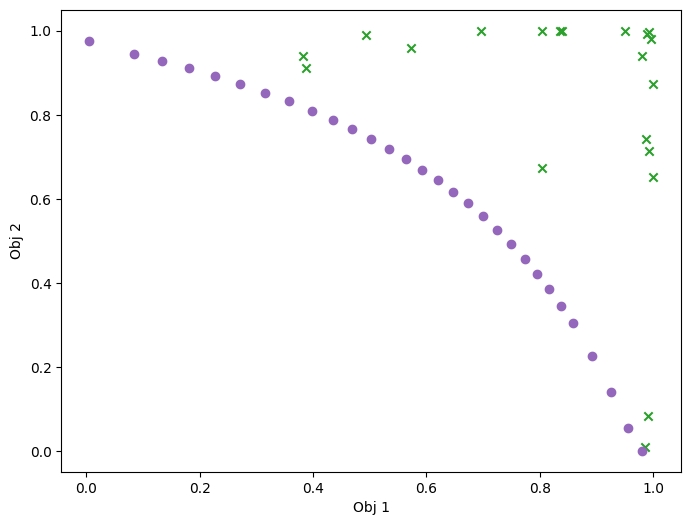

In [9]:
plot_mobo_points_in_obj_space(data_observations, num_init=num_initial_points)
plt.show()

In [10]:
model = result.try_get_final_models()#[OBJECTIVE]
ypreds, yvars = model['OBJECTIVE'].predict(data_query_points)
front = Pareto(data_observations).front
get_reference_point(initial_data.observations)
ref_point = get_reference_point(initial_data.observations)


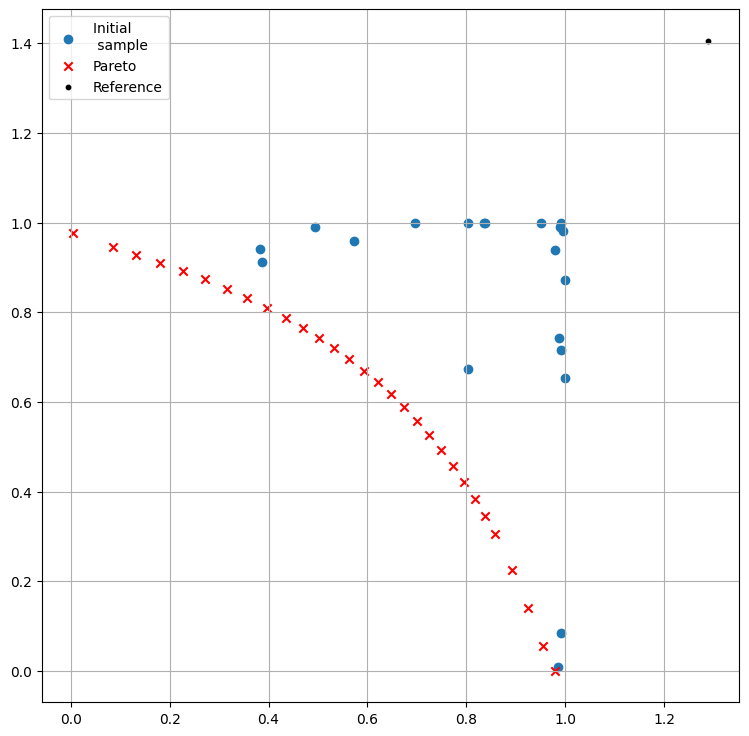

In [11]:
plt.figure(figsize=(9,9))
plt.scatter(initial_data.observations[:,0],initial_data.observations[:,1], c='C0',marker='o', label='Initial \n sample')
plt.scatter(front[:,0], front[:,1], c='r', marker='x', label='Pareto')
plt.scatter(ref_point[0], ref_point[1], c='k', marker='o', s=10, label='Reference')
plt.legend()
plt.grid()


In [12]:
x_min, y_min = search_space._lower.numpy()
x_max, y_max = search_space._upper.numpy()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))


In [13]:
Z, Zvar = model['OBJECTIVE'].predict(np.c_[xx.ravel(), yy.ravel()])


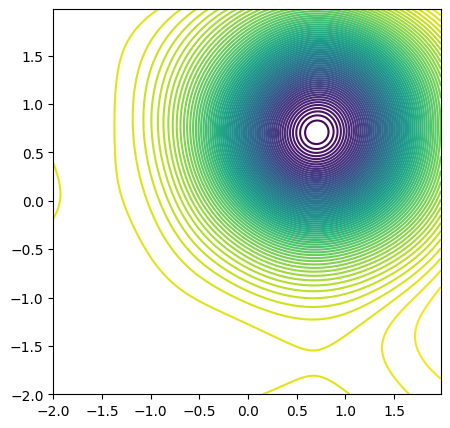

In [14]:
fig, ax = plt.subplots(figsize=(5,5))
ax.contour(xx,yy,Z[:,0].numpy().reshape(*xx.shape), 80, alpha=1)